In [1]:
from typing import List
import random

In [2]:
def is_feasible(solution: List[bool]):
    return any(solution)

In [47]:
def calc_solution_value(
    solution: List[bool],
    cost: List[List[int]],
    facility_cost: List[int],
) -> int:
    
    if not is_feasible(solution):
        return float('inf') # moze suma svih cost i facility_cost
    
    value = 0
    for i, s in enumerate(solution):
        if s:
            value += facility_cost[i]
            
    for i in range(len(cost)):
        min_cost = float('inf')
        for j in range(len(cost[i])):
            if solution[j] and cost[i][j] < min_cost:
                min_cost = cost[i][j]
        value += min_cost
    
    return value

In [53]:
def local_search_invert_first_improvement(
    solution: List[bool],
    value: int,
    cost: List[List[int]],
    facility_cost: List[int],
):
    new_solution = deepcopy(solution)
    improved = True
    while improved:
        improved = False
        unbiased_order = list(range(len(solution)))
        random.shuffle(unbiased_order)
        for i in unbiased_order:
            new_solution[i] = not new_solution[i]
            new_value = calc_solution_value(new_solution, cost, facility_cost)
            if new_value < value:
                value = new_value
                improved = True
                break
            else:
                new_solution[i] = not new_solution[i]
    return new_solution, value

In [5]:
def local_search_invert_best_improvement(
    solution: List[bool],
    value: int,
    cost: List[List[int]],
    facility_cost: List[int],
):
    improved = True
    while improved:
        improved = False
        best_i = None
        best_value = value
        for i in range(len(solution)):
            solution[i] = not solution[i]
            new_value = calc_solution_value(solution, cost, facility_cost)
            if new_value < best_value:
                best_value = new_value
                improved = True
                best_i = i
            solution[i] = not solution[i]
        if improved:
            solution[best_i] = not solution[best_i]
            print(solution)
            value = best_value
    return solution, value

In [6]:
# TODO LS swap

In [7]:
def read_line_of_ints(f):
    return [int(x) for x in f.readline().split()]

In [8]:
def read_instance(file_path: str):
    with open(file_path, 'r') as f:
        m, n = read_line_of_ints(f)
        cost = [read_line_of_ints(f) for _ in range(m)]
        facility_cost = read_line_of_ints(f)
        return cost, facility_cost

In [10]:
cost, facility_cost = read_instance('03/uflp1.txt')

In [11]:
cost

[[1, 12, 3], [2, 7, 41], [19, 21, 7]]

In [12]:
facility_cost

[12, 11, 13]

In [13]:
def initialize(num_facilities):
    return [random.random() < 0.25 for _ in range(num_facilities)]

In [14]:
solution = initialize(len(facility_cost))
value = calc_solution_value(solution, cost, facility_cost)
print(solution)
print(value)
local_search_invert_best_improvement(solution, value, cost, facility_cost)

[False, False, False]
inf
[True, False, False]


([True, False, False], 34)

In [17]:
from copy import deepcopy

In [19]:
def make_small_change(solution: List[bool]):
    new_solution = deepcopy(solution)
    random_idx = random.randrange(len(solution))
    new_solution[random_idx] = not new_solution[random_idx]
    return new_solution

In [30]:
from matplotlib import pyplot as plt

In [33]:
def simulated_annealing(cost, facility_cost, num_iters):
    solution = initialize(len(facility_cost))
    value = calc_solution_value(solution, cost, facility_cost)
    best_solution = deepcopy(solution)
    best_value = value
    
    values = [None for _ in range(num_iters)]
    for i in range(1, num_iters + 1):
        new_solution = make_small_change(solution)
        new_value = calc_solution_value(new_solution, cost, facility_cost)
        
        if new_value < value:
            value = new_value
            solution = deepcopy(new_solution)
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
        else:
            if random.random() < 1 / i:
                value = new_value
                solution = deepcopy(new_solution)
        
        values[i - 1] = value
        
    plt.plot(range(num_iters), values)
    return best_solution, best_value

([True, False, False], 34)

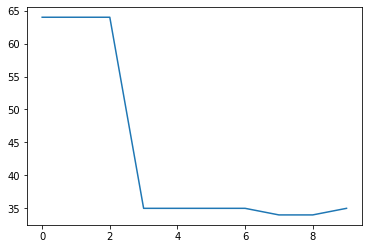

In [34]:
simulated_annealing(cost, facility_cost, num_iters=10)

In [35]:
def shaking(solution, k):
    new_solution = deepcopy(solution)
    chosen_indices = random.sample(range(len(solution)), k)
    for idx in chosen_indices:
        new_solution[idx] = not new_solution[idx]
    return new_solution

In [36]:
from time import perf_counter

In [64]:
def vns(cost: List[List[int]], facility_cost: List[int], vns_params: dict):
    start_time = perf_counter()
    solution = initialize(len(facility_cost))
    value = calc_solution_value(solution, cost, facility_cost)
    while perf_counter() - start_time < vns_params['time_limit']:
        for k in range(vns_params['k_min'], vns_params['k_max']):
            new_solution = shaking(solution, k) # diverzifikacija
            new_value = calc_solution_value(new_solution, cost, facility_cost)
            new_solution, new_value = local_search_invert_first_improvement(
                new_solution,
                new_value,
                cost,
                facility_cost
            ) # intenzifikacija
#             print(new_solution)
            if new_value < value or (new_value == value and random.random() < vns_params['move_prob']):
                value = new_value
                solution = deepcopy(new_solution)
#             print(solution)
    return solution, value

In [65]:
vns_params = {
    'time_limit': 2,
    'k_min': 1,
    'k_max': 2,
    'move_prob': 0.5,
}
vns(cost, facility_cost, vns_params)

([True, False, False], 34)

In [73]:
def read_bk_instance(file_path: str = 'BildeKrarup/B/B1.1'):
    with open(file_path, 'r') as f:
        f.readline()
        num_resources, num_users, _ = read_line_of_ints(f)
        cost = [[None for _ in range(num_users)] for _ in range(num_resources)]
        facility_cost = [None for _ in range(num_resources)]
        for i in range(num_resources):
            ints = read_line_of_ints(f)
            cost[i] = ints[2:]
            facility_cost[i] = ints[1]
    return np.array(cost).transpose(), facility_cost

In [74]:
cost, facility_cost = read_bk_instance()

In [77]:
import numpy as np

In [81]:
vns(cost, facility_cost, vns_params)

([False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False],
 23468)

([False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False],
 23932)

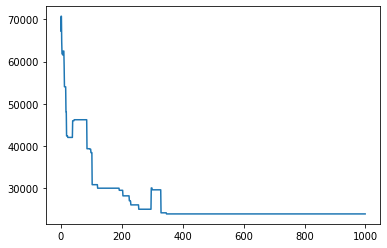

In [83]:
simulated_annealing(cost, facility_cost, num_iters=1000)